In [1]:
library(dplyr)
library(tibble)
library(tidyr)
library(umap)

library(RColorBrewer)
library(ggplot2)
library(cowplot)

theme_set(theme_bw())

options(repr.plot.width = 8, repr.plot.height = 4)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


********************************************************
Note: As of version 1.0.0, cowplot does not change the
  default ggplot2 theme anymore. To recover the previous
  behavior, execute:
  theme_set(theme_cowplot())
********************************************************



In [2]:
source("../R/calc.R")
source("../R/misc.R")
source("../R/normalise.R")
source("../R/plot.R")
source("../R/predict.R")
source("../R/subset.R")
source("../R/utils.R")

## Import data

In [3]:
# Metadata
METADATA_SID <- "../data/GSE67684/processed/metadata/sid-metadata_v2.tsv"
METADATA_PID <- "../data/GSE67684/processed/metadata/pid-metadata_v7.tsv"
metadata_sid <- read.table(METADATA_SID, sep = "\t")
metadata_pid <- read.table(METADATA_PID, sep = "\t", row.names = 1, quote = '"')

## Data
# Removed outliers, patients with timepoints from different batches and batch 5
SUBSET_RPATH <- "../data/GSE67684/processed/subset_yeoh.tsv"
raw_yeoh <- read.table(SUBSET_RPATH, sep = "\t")

In [4]:
# Metadata
metadata_sid$label <- as.factor(metadata_sid$label)
levels(metadata_sid$label) <- c('Remission', 'Relapse')
metadata_sid$batch_info <- as.factor(metadata_sid$batch_info) 
metadata_pid$label <- as.factor(metadata_pid$label)
levels(metadata_pid$label) <- c('Remission', 'Relapse')

# SCALE->REMOVE->FILTER->LOG
scaled_yeoh <- normaliseMeanScaling(raw_yeoh)
selected_yeoh <- removeProbesets(scaled_yeoh)
yeoh <- log2_transform(filterProbesets(selected_yeoh, 0.7, metadata_sid))

# All features
yeoh_allps <- log2_transform(scaled_yeoh)
yeoh_unfltr <- log2_transform(selected_yeoh)

  P001_D0   P004_D0   P005_D0   P007_D0   P008_D0   P009_D0 
 5.796952  4.123342  3.981577  6.317643  4.841458 11.978124 
[1] "No. of ambiguous and AFFY probesets removed: 10503"
[1] D0 D0 D0 D0 D0 D0
Levels: D0 D8 N
           D0    D8     N
1053_at  TRUE  TRUE  TRUE
117_at  FALSE  TRUE  TRUE
121_at   TRUE  TRUE  TRUE
1294_at  TRUE  TRUE  TRUE
1316_at  TRUE  TRUE  TRUE
1320_at FALSE FALSE FALSE
[1] "No. of probesets removed = 6321"


### Commonly used globals

#### All train set (incl. hyperdiploid, others)
- For feature investigation. Remove hypodiploid
- Not required in code!

#### All train set (excl. hyperdiploid, others)
- Does not contain heterogeneous subtypes and MRD NA samples

#### Train/test split (excl. hyperdiploid, others)
- Test set does not contain heterogeneous subtypes and MRD NA samples
- Training set should have the same distribution as test set

In [5]:
### GLOBAL VARIABLES
metadata <- metadata_sid[colnames(yeoh),]
heatmap_metadata <- metadata[, c("batch_info", "label"), drop = F]
COL_LABEL <- c("darkolivegreen3", "tomato3")
names(COL_LABEL) <- c('Remission', 'Relapse')

# List subtypes
subtypes9 <- levels(metadata_sid$subtype)
subtypes7 <- setdiff(subtypes9, c("Hypodiploid", "Normal"))
subtypes6 <- setdiff(subtypes7, "Others")
subtypes5 <- setdiff(
  subtypes9,
  c("Hypodiploid", "Normal", "Hyperdiploid", "Others")
)
others <- yeoh[, metadata$subtype == "Others"]
others_normal <- yeoh[, metadata$subtype %in% c("Others", "Normal")]

# Define train/test split
sid_mrd_na <- rownames(metadata_pid)[is.na(metadata_pid$d33_mrd)] %>%
  rep(each = 2) %>%
  paste0(c("_D0", "_D8"))

sid_alltrain_local <- rownames(metadata)[
  !(metadata$subtype %in% c("Hypodiploid", "Normal")) &
  !(rownames(metadata) %in% sid_mrd_na)
]
sid_alltrain <- rownames(metadata)[
  !(metadata$subtype %in% c("Hypodiploid", "Hyperdiploid", "Others", "Normal")) &
  !(rownames(metadata) %in% sid_mrd_na)
]
sid_train <- rownames(metadata)[
  metadata$batch_info %in% 1:7 &
  !(metadata$subtype %in% c("Hypodiploid", "Hyperdiploid", "Others", "Normal")) &
  !(rownames(metadata) %in% sid_mrd_na)
]
sid_test <- rownames(metadata)[
  metadata$batch_info %in% 8:10 &
  !(metadata$subtype %in% c("Hypodiploid", "Hyperdiploid", "Others", "Normal")) &
  !(rownames(metadata) %in% sid_mrd_na)
]

sid_remission <- rownames(metadata)[metadata$label == 'Remission']
sid_normal <- paste0("N0", c(1,2,4))

### Train/test split: Patients distribution

In [8]:
# # TODO: Do not evaluate to heterogeneous subtypes
# train_distr <- table(
#   Y[sid_train, "subtype"],
#   Y[sid_train, "label"]
# )/2
# test_distr <- table(
#   Y[sid_test, "subtype"],
#   Y[sid_test, "label"]
# )/2

# # # Transfer all relapse samples to test set
# # test_distr[, 2]<- test_distr[, 2] + train_distr[, 2]
# # train_distr[, 2] <- 0

# print(xtable(train_distr, display = rep("d", 3)))
# print(xtable(test_distr, display = rep("d", 3)))

## Relapse prediction

Factors of variation: Timepoint, batch, subtype, remission

### Batch genes

Constant: Timepoint, subtype , remission

In [6]:
batch_ps <- identify_batch_features(yeoh, metadata, method = 'aov')
length(batch_ps)

[1] "No. of NaNs = 0"


[1] 2565

### Drug genes

Constant: Subtype, remission

### M1: Entire data

In [8]:
# list_subtype_sids <- lapply(
#   subtypes7,
#   function(subtype) {
#     sid_alltrain_local[metadata_sid[sid_alltrain_local, "subtype"] == subtype]
#   }
# )

In [7]:
X_normal <- yeoh[, sid_normal]
list_X_subtypes7 <- lapply(
  subtypes7,
  function(subtype) {
    yeoh[, sid_alltrain_local[metadata_sid[sid_alltrain_local, "subtype"] == subtype]]
  }
)
list_obj <- lapply(
  list_X_subtypes7,
  predict_pipeline,
  X_normal,
  metadata,
  metadata_pid,
  batch_ps
)
names(list_obj) <- subtypes7

No. of NaN values in log-fc = 0
No. of probesets excluded by expr threshold = 725
No. of features (p-value) = 170
No. of features (log2-fc) = 214
No. of DE features = 21
No. of final features = 14
No. of samples in centroid = 5
No. of remission samples in training set = 5
Prediction complete!

No. of NaN values in log-fc = 0
No. of probesets excluded by expr threshold = 818
No. of features (p-value) = 744
No. of features (log2-fc) = 753
No. of DE features = 239
No. of final features = 164
No. of samples in centroid = 5
No. of remission samples in training set = 5
Prediction complete!

No. of NaN values in log-fc = 0
No. of probesets excluded by expr threshold = 718
No. of features (p-value) = 2508
No. of features (log2-fc) = 283
No. of DE features = 281
No. of final features = 216
No. of samples in centroid = 31
No. of remission samples in training set = 31
Prediction complete!

No. of NaN values in log-fc = 0
No. of probesets excluded by expr threshold = 487
No. of features (p-value) 

### Plot boxplots (comparing labels)

In [8]:
list_X_y <- lapply(list_obj, function(obj) obj$X_y)
boxplots <- lapply(list_X_y, plot_boxplot, fill = 'label')
names(boxplots) <- subtypes7

Warning message in wilcox.test.default(x1, x2, exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x1, x2, exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x1, x2, exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x1, x2, exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x1, x2, exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x1, x2, exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x1, x2, exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x1, x2, exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x1, x2, exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x1, x2, exact = T):
“cannot compute exact p-value with ties”Warning me

#### Plot B-Others

In [73]:
names(list_X_y) <- subtypes7
X_y_ot <- list_X_y$Others
X_y_ot1 <- cbind(
  X_y_ot,
  subtype = metadata_otno[paste0(rownames(X_y_ot), '_D0'), 'newsubtype']
)

In [77]:
source("../R/plot.R")
options(repr.plot.width = 8, repr.plot.height = 4)

In [81]:
boxplot_others <- plot_boxplot(X_y_ot1, fill = 'subtype', p.value = FALSE, show.legend = TRUE)
ggsave('~/Dropbox/tmp/boxplot-others.pdf', boxplot_others, width = 10, height = 2.5)

### Calculate effect size
#### Cohen's d (assuming unequal variance)
$ d = \frac{x_1 - x_2}{s} $, $ s = \sqrt{\frac{s_1^2 + s_2^2}{2}} $

In [562]:
for (subtype in subtypes7) {
  file <- sprintf('~/Dropbox/tmp/boxplot-%s.pdf', subtype)
  ggsave(file, boxplots[[subtype]], width = 9.5, height = 2.5)
}

### Save probabilities (w/o heterogeneous subtypes)

In [68]:
list_p_d8 <- lapply(list_obj, function(obj) obj$X_y["p_d8"])
p_d8 <- do.call(rbind, unname(list_p_d8[subtypes5]))

In [69]:
list_p_d33 <- lapply(list_obj, function(obj) obj$X_y["p_d33"])
p_d33 <- do.call(rbind, unname(list_p_d33[subtypes5]))

In [70]:
write.table(p_d8, "../tmp/p_d8.tsv", quote = F, sep = "\t")
write.table(p_d33, "../tmp/p_d33.tsv", quote = F, sep = "\t")

## Plot: Relapse OR HR v.s. Remission AND NOT HR
- Change label column

In [679]:
add_treatment <- function(obj, metadata_pid) {
  # Adds column - required_treatment: {non-intensive, intensive}
  X_y <- obj$X_y
  treatment <- as.character(metadata_pid[rownames(X_y), 'treatment_processed'])
  names(treatment) <- rownames(X_y)
  treatment <- treatment[!is.na(treatment)] # remove NA values in treatment
  consolidated_treatment <- treatment
  idx <- consolidated_treatment %in% c('HR1', 'HR2')
  consolidated_treatment[idx] <- 'HR'
  consolidated_treatment[!idx] <- 'SR/IR'
  required_treatment <- factor(
    'Non-intensive',
    levels = c('Non-intensive', 'Intensive')
  )
  pid_info <- data.frame(
    treatment,
    consolidated_treatment,
    label = X_y[names(treatment), 'label'],
    required_treatment = required_treatment
  )
  idx_intensive <- pid_info$label == 'Relapse' | pid_info$consolidated_treatment == 'HR'
  pid_info$required_treatment[idx_intensive] <- 'Intensive'
  
  X_y <- X_y[rownames(pid_info), ] # remove patients with treatment NA values
  X_y$treatment <- pid_info$treatment
  X_y$required_treatment <- pid_info$required_treatment # add column to X_y
  
  return(X_y)
}

In [671]:
list_X_y1 <- lapply(list_obj, add_treatment, metadata_pid)

boxplots1 <- lapply(
  list_X_y1, plot_boxplot,
  group = 'required_treatment', fill = 'label', pch = 'treatment'
)

Warning message in wilcox.test.default(x1, x2, exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x1, x2, exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x1, x2, exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x1, x2, exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x1, x2, exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x1, x2, exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x1, x2, exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x1, x2, exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x1, x2, exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x1, x2, exact = T):
“cannot compute exact p-value with ties”Warning me

In [672]:
for (subtype in subtypes7) {
  file <- sprintf('~/Dropbox/tmp/boxplot_newlabel-%s.pdf', subtype)
  ggsave(file, boxplots1[[subtype]], width = 9.5, height = 2.5)
}

### Estimate probabilities (with Wk12 MRD)

In [59]:
X_normal <- yeoh[, sid_normal]
list_X_subtypes7 <- lapply(
  subtypes7,
  function(subtype) {
    yeoh[, sid_alltrain_local[metadata_sid[sid_alltrain_local, "subtype"] == subtype]]
  }
)
list_obj1 <- lapply(
  list_X_subtypes7,
  predict_pipeline,
  X_normal,
  metadata,
  metadata_pid,
  batch_ps,
  include_tp2 = TRUE
)
names(list_obj1) <- subtypes7

No. of NaN values in log-fc = 0
No. of probesets excluded by expr threshold = 725
No. of features (p-value) = 170
No. of features (log2-fc) = 214
No. of DE features = 21
No. of final features = 14
No. of samples in centroid = 5
Omitted patients: P054!
 Omitted patients: P134!
 Omitted patients: P170!
 Omitted patients: P184!
No. of remission samples in training set = 3
Prediction complete!

No. of NaN values in log-fc = 0
No. of probesets excluded by expr threshold = 818
No. of features (p-value) = 744
No. of features (log2-fc) = 753
No. of DE features = 239
No. of final features = 164
No. of samples in centroid = 5
No. of remission samples in training set = 5
Prediction complete!

No. of NaN values in log-fc = 0
No. of probesets excluded by expr threshold = 718
No. of features (p-value) = 2508
No. of features (log2-fc) = 283
No. of DE features = 281
No. of final features = 216
No. of samples in centroid = 31
Omitted patients: P038!
 Omitted patients: P041!
 Omitted patients: P046!
 Om

In [71]:
list_p_tp2 <- lapply(list_obj1, function(obj) obj$X_y["p_tp2"])
p_tp2 <- do.call(rbind, unname(list_p_tp2[subtypes5]))

In [72]:
write.table(p_tp2, "../tmp/p_tp2.tsv", quote = F, sep = "\t")

#### Estimate probability using simulated samples
- Features are modelled as normal distributions (median, sd)

In [338]:
# list_obj2 <- lapply(
#   list_X_subtypes7,
#   predict_pipeline,
#   X_normal,
#   metadata, metadata_pid,
#   batch_ps,
#   samples = 300
# )
# names(list_obj2) <- subtypes7

### Overall ROC
- Estimating probability of remission by calculating percentage of samples in training set with a worse score
- Subtype specific model during estimation
- Combine probability predictions into an overall ROC curve

### M1: Train/test

### M1: Test set 1 (w/o Hyp, Others)

In [36]:
names(list_X_subtypes7) <- subtypes7
list_X_subtypes5 <- list_X_subtypes7[subtypes5]

In [37]:
list_train_test <- lapply(
  list_X_subtypes5,
  predict_pipeline,
  X_normal,
  metadata,
  metadata_pid,
  batch_ps,
  sid_train_test = list(sid_train, sid_test)
)

No. of NaN values in log-fc = 0
No. of probesets excluded by expr threshold = 760
No. of features (p-value) = 132
No. of features (log2-fc) = 326
No. of DE features = 24
No. of final features = 18
No. of samples in centroid = 4
No. of remission samples in training set = 4
No. of remission samples in training set = 4
Prediction complete!

No. of NaN values in log-fc = 0
No. of probesets excluded by expr threshold = 1105
No. of features (p-value) = 356
No. of features (log2-fc) = 813
No. of DE features = 123
No. of final features = 79
No. of samples in centroid = 3
No. of remission samples in training set = 3
No. of remission samples in training set = 3
Prediction complete!

No. of NaN values in log-fc = 0
No. of probesets excluded by expr threshold = 384
No. of features (p-value) = 459
No. of features (log2-fc) = 1281
No. of DE features = 164
No. of final features = 109
No. of samples in centroid = 2
No. of remission samples in training set = 2
No. of remission samples in training set =

### Save probabilities

In [39]:
# list_p_d8_train <- lapply(list_train_test, function(obj) obj$train$X_y["p_d8"])
# p_d8_train <- do.call(rbind, unname(list_p_d8_train))

# list_p_d8_test <- lapply(list_train_test, function(obj) obj$test$X_y["p_d8"])
# p_d8_test <- do.call(rbind, unname(list_p_d8_test))
                         
list_p_d33_train <- lapply(list_train_test, function(obj) obj$train$X_y["p_d33"])
p_d33_train <- do.call(rbind, unname(list_p_d33_train))

list_p_d33_test <- lapply(list_train_test, function(obj) obj$test$X_y["p_d33"])
p_d33_test <- do.call(rbind, unname(list_p_d33_test))

In [40]:
# write.table(p_d8_train, "../tmp/p_d8-train.tsv", quote = F, sep = "\t")
# write.table(p_d8_test, "../tmp/p_d8-test.tsv", quote = F, sep = "\t")

write.table(p_d33_train, "../tmp/p_d33-train.tsv", quote = F, sep = "\t")
write.table(p_d33_test, "../tmp/p_d33-test.tsv", quote = F, sep = "\t")

## TEL-AML
- Demonstrate removal of batch effect probesets

In [566]:
#' Does not perform PCA transform on data
#' Used to predict relapse for all subtypes
#' X df containing all subtypes of patients in arg: pid and normal patients
#' @param pid vector of pid belonging to both D0 and D8 patients (identically ordered)
#' @param sid_train_test list of length 2 in the form of (sid_train, sid_test)
#' @return list containing prediction plot and vector coordinates
get_class_genes <- function(
  X_subtype,
  X_normal,
  metadata_sid,
  metadata_pid,
  sid_train_test = NULL,
  features = c(
    "erm1_ratio2", "l2norm_ratio2",
    "angle_LD0_LD8_ratio2", "log_mrd_d33"
  ),
  direction = c("<", "<", "<", ">")
) {
  if (!is.null(sid_train_test)) {
    stopifnot(length(sid_train_test) == 2)
    sid_train <- intersect(sid_train_test[[1]], colnames(X_subtype))
    sid_test <- intersect(sid_train_test[[2]], colnames(X_subtype))
    # assert that D0 and D8 samples match
    stopifnot(is_paired(sid_train))
    stopifnot(is_paired(sid_test))
  }
  sid_remission <- colnames(X_subtype)[
    metadata_sid[colnames(X_subtype), "label"] == 'Remission'
  ]
  # Feature selection
  # Identify DE features between D0 and D8 samples
  if (!is.null(sid_train_test)) {
    class_genes <- identify_DE(
      X_subtype[, sid_train, drop = FALSE],
      sid_remission
    )
  } else {
    class_genes <- identify_DE(X_subtype, sid_remission)
  }
  
  class_genes
}

In [567]:
names(list_X_subtypes7) <- subtypes7
telaml1 <- list_X_subtypes7[['TEL-AML1']]

In [568]:
telaml1_ps <- get_class_genes(telaml1, X_normal, metadata, metadata_pid)
selected_ps <- setdiff(telaml1_ps, batch_ps)

No. of NaN values in log-fc = 0
No. of probesets excluded by expr threshold = 710
No. of features (p-value) = 2765
No. of features (log2-fc) = 507


In [608]:
ax_top_pc1 <- ggplot_top_pc(
  telaml1[telaml1_ps, ], metadata, x_axis = 'batch_info',
  cex = 2.5, color = 'batch_info', pch = 'class_info'
) +
  labs(x = 'Batch', col = 'Batch', pch = 'Time point')

ax_top_pc2 <- ggplot_top_pc(
  telaml1[selected_ps, ], metadata, x_axis = 'batch_info',
  cex = 2.5, color = 'batch_info', pch = 'class_info'
) +
  labs(x = 'Batch', col = 'Batch', pch = 'Time point')

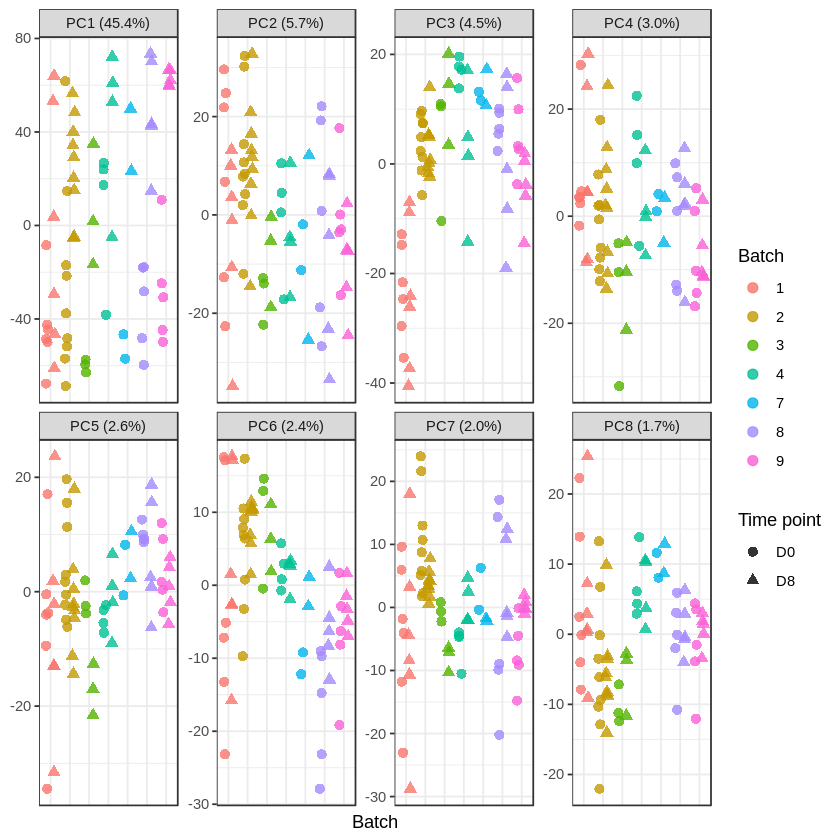

In [609]:
ax_top_pc1

In [611]:
file1 <- '~/Dropbox/tmp/top_pc-telaml1_before.pdf'
file2 <- '~/Dropbox/tmp/top_pc-telaml1_after.pdf'
ggsave(file1, ax_top_pc1, width = 8, height = 4)
ggsave(file2, ax_top_pc2, width = 8, height = 4)

In [204]:
ax_pca1 <- ggplot_pca(
  telaml1[telaml1_ps, ], metadata, cex = 2.5,
  col = 'batch_info', pch = 'class_info'
) +
  labs(col = 'Batch', pch = 'Time point')
ax_pca2 <- ggplot_pca(
  telaml1[selected_ps, ], metadata, cex = 2.5,
  col = 'batch_info', pch = 'class_info'
) +
  labs(col = 'Batch', pch = 'Time point')

In [ ]:
file1 <- '~/Dropbox/tmp/pca-telaml1_before.pdf'
file2 <- '~/Dropbox/tmp/pca-telaml1_after.pdf'
ggsave(file1, ax_pca1, width = 4.5, height = 3.5)
ggsave(file2, ax_pca2, width = 4.5, height = 3.5)

In [205]:
ax_umap1 <- ggplot_umap(
  telaml1[telaml1_ps, ], metadata, cex = 2.5,
  col = 'batch_info', pch = 'class_info'
) +
  labs(col = 'Batch', pch = 'Time point')
ax_umap2 <- ggplot_umap(
  telaml1[selected_ps, ], metadata, cex = 2.5,
  col = 'batch_info', pch = 'class_info'
) +
  labs(col = 'Batch', pch = 'Time point')

In [206]:
file1 <- '~/Dropbox/tmp/umap-telaml1_before.pdf'
file2 <- '~/Dropbox/tmp/umap-telaml1_after.pdf'
ggsave(file1, ax_umap1, width = 4.5, height = 3.5)
ggsave(file2, ax_umap2, width = 4.5, height = 3.5)

# DUX4

In [673]:
PID_DUX4 <- "../tmp/pid-DUX4.txt"
pid_dux4 <- readLines(PID_DUX4)
sid_dux4 <- get_sid(pid_dux4)

# metadata_sid1 <- metadata_sid
# levels(metadata_sid1$subtype) <- c(levels(metadata_sid1$subtype), "DUX4")
# metadata_sid1[sid_dux4, "subtype"] <- "DUX4"

In [674]:
X_normal <- yeoh[, sid_normal]
X_subtype <- yeoh[, sid_dux4]
obj <- predict_pipeline(X_subtype, X_normal, metadata, metadata_pid, batch_ps)

No. of NaN values in log-fc = 0
No. of probesets excluded by expr threshold = 772
No. of features (p-value) = 2564
No. of features (log2-fc) = 679
No. of DE features = 660
No. of final features = 480
No. of samples in centroid = 19
No. of remission samples in training set = 19
Prediction complete!



In [676]:
add_treatment <- function(obj, metadata_pid) {
  # Adds column - required_treatment: {non-intensive, intensive}
  X_y <- obj$X_y
  treatment <- as.character(metadata_pid[rownames(X_y), 'treatment_processed'])
  names(treatment) <- rownames(X_y)
  treatment <- treatment[!is.na(treatment)] # remove NA values in treatment
  consolidated_treatment <- treatment
  idx <- consolidated_treatment %in% c('HR1', 'HR2')
  consolidated_treatment[idx] <- 'HR'
  consolidated_treatment[!idx] <- 'SR/IR'
  required_treatment <- factor(
    'Non-intensive',
    levels = c('Non-intensive', 'Intensive')
  )
  pid_info <- data.frame(
    treatment,
    consolidated_treatment,
    label = X_y[names(treatment), 'label'],
    required_treatment = required_treatment
  )
  idx_intensive <- pid_info$label == 'Relapse' | pid_info$consolidated_treatment == 'HR'
  pid_info$required_treatment[idx_intensive] <- 'Intensive'
  
  X_y <- X_y[rownames(pid_info), ] # remove patients with treatment NA values
  X_y$treatment <- pid_info$treatment
  X_y$required_treatment <- pid_info$required_treatment # add column to X_y
  
  return(X_y)
}

In [704]:
X_y <- add_treatment(obj, metadata_pid)
head(X_y)

,erm1_ratio2,l2norm_ratio2,angle_LD0_LD8_ratio2,log_mrd_d33,p_d8,p_d33,label,treatment,required_treatment
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>
P060,2.2609633,1.3974799,0.5436946,-3.69897,0.3333333,0.4473684,Remission,IR,Non-intensive
P063,0.6173321,0.9174787,0.4324256,-3.00000,0.1052632,0.1973684,Remission,HR1,Intensive
P071,5.0548792,1.4634860,0.6214487,-2.69897,0.5263158,0.5000000,Remission,IR,Non-intensive
P073,2.3434004,1.3656135,0.6268032,-3.30103,0.3859649,0.4210526,Remission,IR,Non-intensive
P076,36.4452859,2.6607007,1.1706164,-3.69897,1.0000000,0.9473684,Remission,IR,Non-intensive
P077,2.5821853,1.4311605,0.6603660,-2.69897,0.4736842,0.4605263,Remission,HR1,Intensive


In [743]:
ax <- plot_boxplot(X_y, group = 'label', fill = 'label')
file <- "~/Dropbox/tmp/boxplot_outcome-DUX4.pdf"
ggsave(file, ax, width = 9.5, height = 2.5)

Warning message in wilcox.test.default(x1, x2, exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x1, x2, exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x1, x2, exact = T):
“cannot compute exact p-value with ties”

## Investigate: B-Others
- Aim: Consolidate subtypes, enrich signal, reduce noise, new framework
- Heterogeneous subtype where underlying subtype information is obscured
- Noise coming from batch effects and individual variability (e.g. normal GEPs)
    - Avoid when zeros are enriched in a certain batch
- SSM: Not modelling DUX4, BCR-ABL1-like and TEL-AML1-like subtypes well
    - Possible reasons
        1. Treatment response vector may be more aligned to certain subtypes (e.g. DUX4). Use of ERM is not a good idea as its value depends on the treatment response vector
        2. ERM ratio and phi depends on both centroids, ARM ratio depends on normal centroid. ERM ratio not good for heterogeneous subtypes
            - Use ERM ratio that calculates treatment response vector from own GEP or k-NN
            - Calculate ARM ratio using each normal GEP and average, or add normal samples
        3. CCR patients showing small treatment response!
        4. Noise captured during feature selection step. Not enough signal
            - Remove features that are lowly expressed
            - IQR (Big IQR)
    - Possible improvements
        - Finding a way to standarize and compare different subtypes?
        - Features
            1. Start and end position
            2. Distance moved
            3. Misc (trajectory)
        - Plot ARM ratio, ...,  against end position
        - Consolidate ratios across subtypes

#### TO-DO
1. Features: Using HVGs and suppressing noise
2. Exploring alternatives to ERM
    - ERM using own D0
3. Exploring averaging the normal GEPs
4. Exploring integrating the first and final positions
5. Taking advantage by averaging across the genes

## Features
- All: Batch effect present
- HVG50, Response: Subtypes appear
- Progression signal is strong, subtype signal is weaker than individual variability?
- What if we use BCR-ABL signature? DUX4?
- Discarding PCs as a way of dealing with noise? Selecting PCs?

#### Take-aways
- Even though there is a great deal of noise, k-NN of a point is still largely dominated by the same subtype
- Heterogeneous subtype: Move away from having one treatment response vector and alter the feature selection step

In [9]:
others <- yeoh[, metadata$subtype == 'Others']
normal <- yeoh[, metadata$subtype == 'Normal']
ps_response <- identify_DE(others, sid_remission)
others_normal <- cbind(others, normal)

No. of NaN values in log-fc = 0
No. of probesets excluded by expr threshold = 822
No. of features (p-value) = 3081
No. of features (log2-fc) = 448


In [37]:
on_response <- others_normal[ps_response, ]
on_nobatch <- others_normal[!(rownames(others) %in% batch_ps), ]
on_hvg50 <- select_hvg(others_normal, 50)
on_hvg100 <- select_hvg(others_normal, 100)

#### Exploring features
- Comparing variance of others v.s. normal

In [230]:
var_otno <- matrix(0, nrow = 100, ncol = 2)
colnames(var_otno) <- c('Variance (B-Others)', 'Variance (Normal)')
is_norm <- startsWith(colnames(on_hvg100), 'N')

for (i in seq(1, 100)) {
  var_otno[i, 1] <- var(as.numeric(on_hvg100[i, !is_norm]))
  var_otno[i, 2] <- var(as.numeric(on_hvg100[i, is_norm]))
}

In [233]:
pdf('~/Dropbox/tmp/var-otno.pdf', width = 5, height = 5)
plot(var_otno, xlim = c(0, 25))
dev.off()

png 
  2

In [234]:
i <- 1

[1] 19


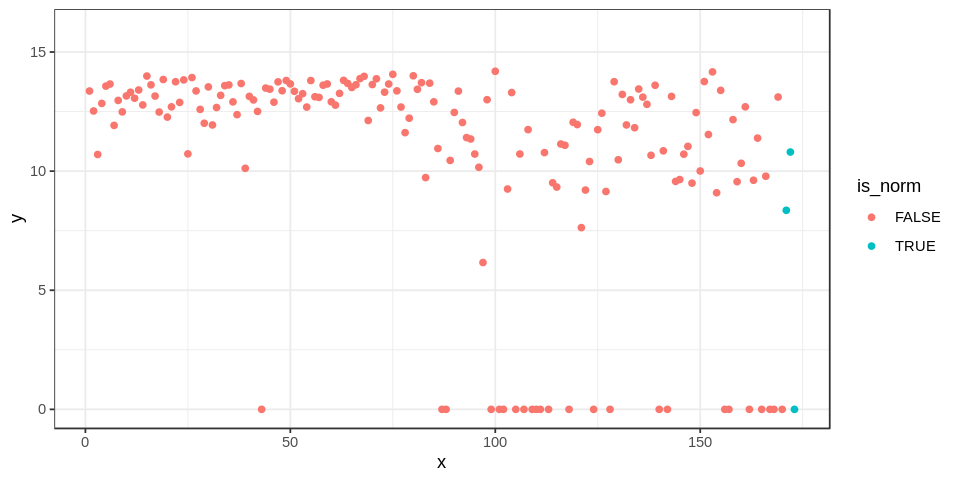

In [252]:
i <- i + 1
print(i)
x <- 1:ncol(on_hvg100)
y <- as.numeric(on_hvg100[i,])

ggplot() +
  geom_point(aes(x = x, y = y, col = is_norm)) +
  ylim(c(0, 16))

In [253]:
normal_high <- which(var_otno[, 2] > 10)
on_hvg100_lvar <- on_hvg100[-normal_high, ]

In [12]:
# Label B-Others with DUX4 and etc.
file1 <- '../tmp/pid-DUX4.txt'
file2 <- '../tmp/pid-BCR-ABL-like.txt'
file3 <- '../tmp/pid-TEL-AML1-like.txt'

pid_dux4 <- readLines(file1)
pid_bcrabl <- readLines(file2)
pid_telaml1 <- readLines(file3)

sid_dux4 <- get_sid(pid_dux4)
sid_bcrabl <- get_sid(pid_bcrabl)
sid_telaml1 <- get_sid(pid_telaml1)

In [13]:
metadata_otno <- subset(metadata_sid, subtype %in% c('Others', 'Normal'))
metadata_otno$newsubtype <- as.character(metadata_otno$subtype)
metadata_otno$newsubtype[rownames(metadata_otno) %in% sid_dux4] <- 'DUX4'
metadata_otno$newsubtype[rownames(metadata_otno) %in% sid_bcrabl] <- 'BCR-ABL-like'
metadata_otno$newsubtype[rownames(metadata_otno) %in% sid_telaml1] <- 'TEL-AML1-like'

In [33]:
on_d0 <- on_response[endsWith(colnames(on_response), 'D0')]
on_hvg_d0 <- on_hvg100[endsWith(colnames(on_response), 'D0')]

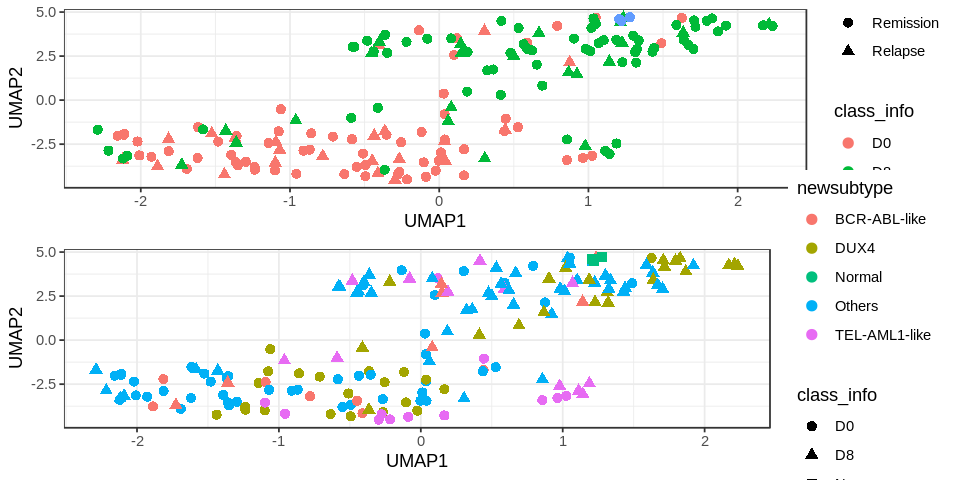

In [256]:
ax_umap1 <- ggplot_umap(
  on_hvg100_lvar, metadata_otno,
  cex = 2.5, col = 'class_info', pch = 'label'
)
ax_umap2 <- ggplot_umap(
  on_hvg100_lvar, metadata_otno,
  cex = 2.5, col = 'newsubtype', pch = 'class_info'
)
ax_umap3 <- plot_grid(ax_umap1, ax_umap2, nrow = 2)
ax_umap3
# ggsave('~/Dropbox/tmp/umap-response.pdf', ax_umap3, width = 8, height = 8)

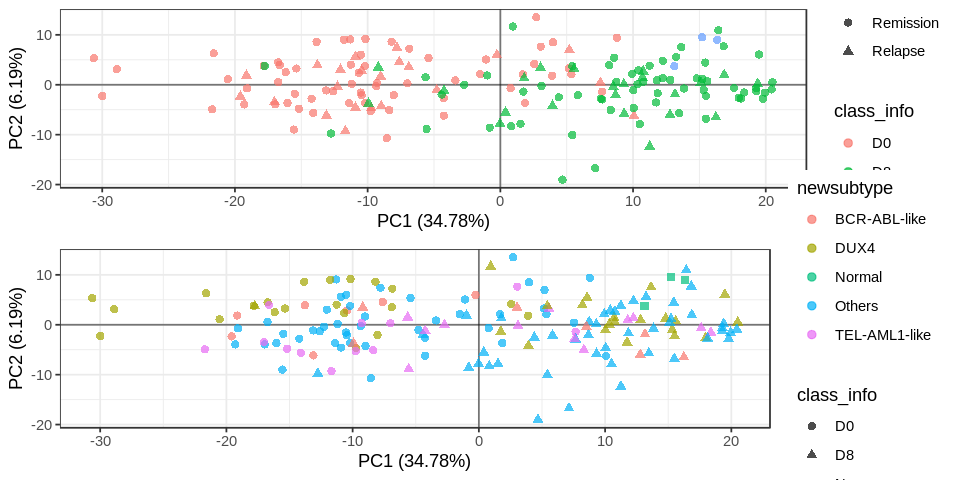

In [310]:
ax1 <- ggplot_pca(
  on_response, metadata_otno,
  x = 'PC1', y = 'PC2',
  colour = 'class_info', shape = 'label',
  show.legend = TRUE
)
ax2 <- ggplot_pca(
  on_response, metadata_otno,
  x = 'PC1', y = 'PC2',
  colour = 'newsubtype', shape = 'class_info',
  show.legend = TRUE
)
ax3 <- plot_grid(ax1, ax2, nrow = 2)
ax3
# ggsave('~/Dropbox/tmp/pca-hvg100.pdf', ax3, width = 8, height = 8)

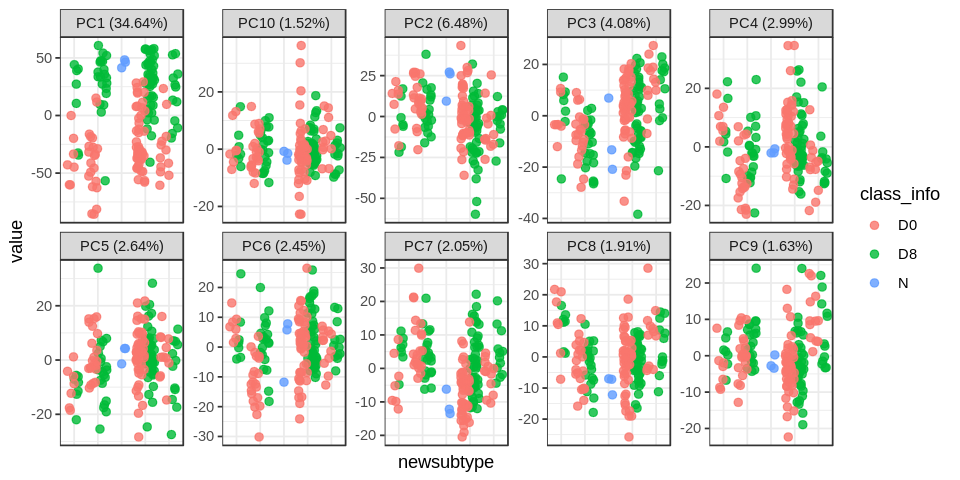

In [170]:
ggplot_top_pc(
  on_response, metadata_otno,
  'newsubtype', n = 10, color = 'class_info'
)

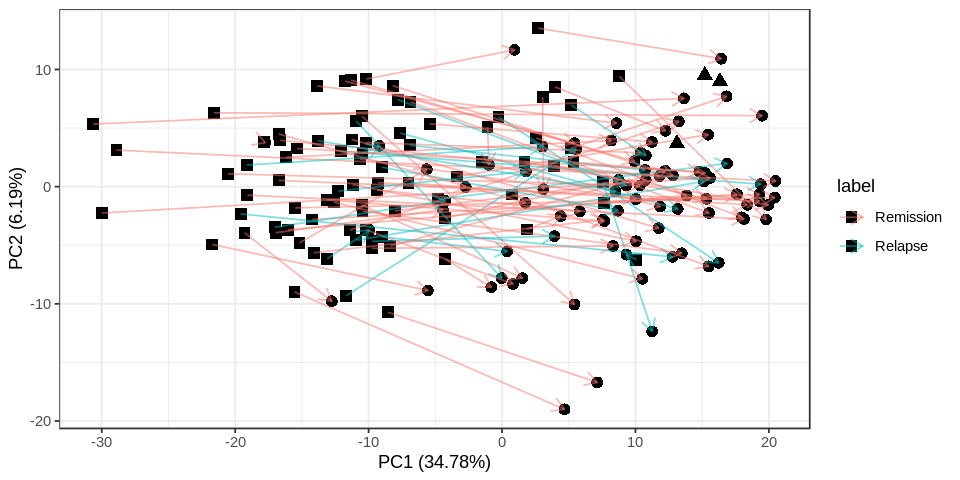

In [311]:
plot_vectors(on_response, metadata)

In [262]:
X_normal <- yeoh[, sid_normal]
list_X_subtypes7 <- lapply(
  subtypes7,
  function(subtype) {
    yeoh[, sid_alltrain_local[metadata_sid[sid_alltrain_local, "subtype"] == subtype]]
  }
)
names(list_X_subtypes7) <- subtypes7

In [281]:
source("../R/predict.R")

In [282]:
V_others <- predict_pipeline(
  list_X_subtypes7$Others, X_normal,
  metadata, metadata_pid, batch_ps,
  return_features = TRUE
)

No. of NaN values in log-fc = 0
No. of probesets excluded by expr threshold = 822
No. of features (p-value) = 3081
No. of features (log2-fc) = 448
No. of DE features = 448
No. of final features = 342
No. of samples in centroid = 63


In [284]:
features <- c('erm1_ratio2', 'erm2_ratio2')
V_ot_sub <- V_others[features]
rownames(V_others)

In [292]:
V_ot_sub1 <- cbind(
  V_ot_sub,
  metadata_otno[paste0(rownames(V_others), '_D0'), c('newsubtype', 'label')]
)

In [296]:
V_long <- gather(V_ot_sub1, key = 'feature', value = 'value', -c('newsubtype', 'label'))

In [301]:
head(V_long)

newsubtype,label,feature,value
<chr>,<fct>,<chr>,<dbl>
Others,Remission,erm1_ratio2,0.7176630
DUX4,Remission,erm1_ratio2,1.8488403
Others,Remission,erm1_ratio2,15.6133182
BCR-ABL-like,Relapse,erm1_ratio2,1.7872220
DUX4,Remission,erm1_ratio2,0.6265548
Others,Remission,erm1_ratio2,0.8360724


Warning message:
“Removed 4 rows containing missing values (geom_point).”

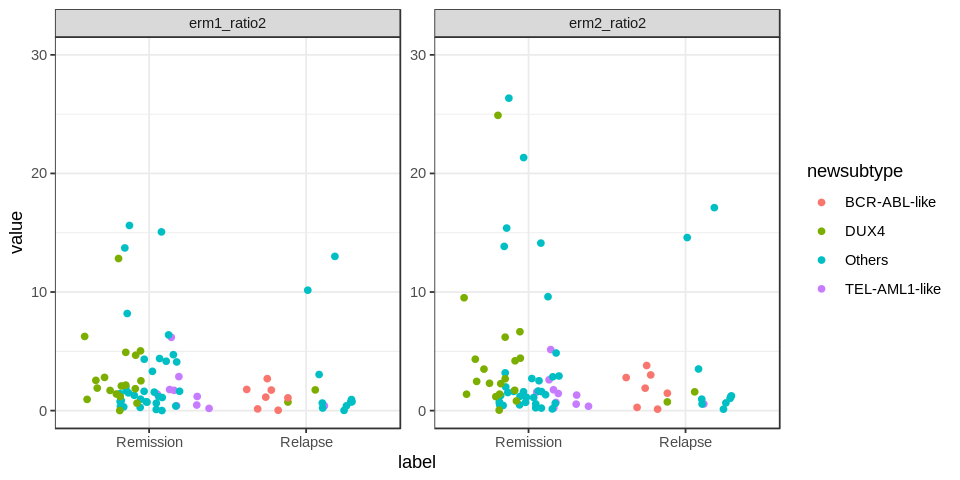

In [312]:
ggplot(V_long) +
  facet_wrap(~feature, scales = 'free') +
  geom_point(
    aes(x = label, y = value, color = newsubtype),
    position = position_jitterdodge()
  ) +
  ylim(c(0, 30))